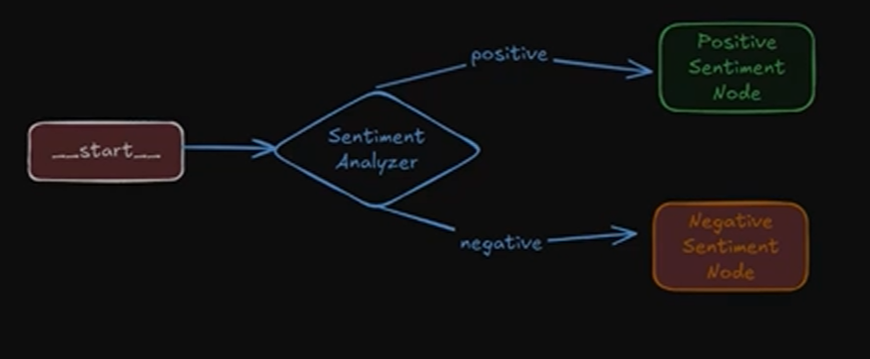

In [1]:
from dotenv import load_dotenv
import os

load_dotenv('../.env')

True

In [19]:
from typing_extensions import Literal , TypedDict
from langgraph.graph import  StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph.message import add_messages 
from langchain_groq import ChatGroq
from pydantic import BaseModel , Field
import os

In [ ]:
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.0,
    max_retries=2,
    api_key=os.getenv("GROQ_API_KEY")
)


In [11]:
class SentimentAnalysis(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(..., description="The sentiment of the text.")
    confidence: float = Field(..., description="The confidence score of the sentiment analysis from 0.0 to 1.0.")
    reason: str = Field(..., description="The reason for the sentiment classification.")

### state

In [25]:
class SentimentState(TypedDict):
    original_tweet: str
    sentiment: str 
    confidence: float
    response_tweet: str

### nodes


In [56]:
def analyze_sentiment(state: SentimentState) -> SentimentState:
    tweet = state['original_tweet']
    print(f"Analyzing sentiment for tweet {tweet} ......... ")

    structured_llm = llm.with_structured_output(SentimentAnalysis)
    system_message = SystemMessage(content="You are a sentiment analysis model. Analyze the sentiment of the given tweet and provide a sentiment (positive or negative), a confidence score between 0.0 and 1.0, and a reason for your classification.")
    human_message = HumanMessage(content=f"Tweet: {tweet}")

    messages = [system_message, human_message]
    response = structured_llm.invoke(messages)
    print(response)
    # state["sentiment"] = response.sentiment
    # state["confidence"] = response.confidence
    return SentimentState(original_tweet = tweet, sentiment=response.sentiment, confidence=response.confidence, response_tweet="")

In [57]:
state = {"original_tweet": "I love using LangGraph! It's so intuitive and powerful."}
analyze_sentiment(state)

Analyzing sentiment for tweet I love using LangGraph! It's so intuitive and powerful. ......... 
sentiment='positive' confidence=0.9 reason="The tweet contains positive words such as 'love' and phrases like 'so intuitive and powerful'."


{'original_tweet': "I love using LangGraph! It's so intuitive and powerful.",
 'sentiment': 'positive',
 'confidence': 0.9,
 'response_tweet': ''}

In [58]:
def generate_positive_response(state: SentimentState) -> SentimentState:
    tweet = state['original_tweet']
    print(f"Generating positive response for tweet {tweet} ......... ")

    system_message = SystemMessage(content="You are a helpful assistant that generates positive responses to tweets.")
    human_message = HumanMessage(content=f"Original Tweet: {tweet}\nGenerate a positive response to this tweet.")

    messages = [system_message, human_message]
    response = llm.invoke(messages)
    state["response_tweet"] = response
    return state

In [59]:
generate_positive_response(SentimentState(original_tweet="I hate waiting in long lines at the grocery store."))

Generating positive response for tweet I hate waiting in long lines at the grocery store. ......... 


{'original_tweet': 'I hate waiting in long lines at the grocery store.',
 'response_tweet': AIMessage(content='"Waiting in line can be frustrating, but think of it as a chance to catch up on your favorite podcast or connect with a friend. Plus, you\'re one step closer to getting home and enjoying a delicious meal! #GroceryShopping #PatienceIsAPractice"', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 69, 'total_tokens': 126, 'completion_time': 0.099421323, 'prompt_time': 0.003932531, 'queue_time': 0.055755875, 'total_time': 0.103353854}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--5a301845-a99f-47a9-951b-541bedc7cd1a-0', usage_metadata={'input_tokens': 69, 'output_tokens': 57, 'total_tokens': 126})}

In [60]:
def generate_negative_response(state : SentimentState) -> SentimentState:
    tweet = state['original_tweet']
    print(f"Generating negative response for tweet {tweet} ......... ")

    system_message = SystemMessage(content="You are a helpful assistant that generates negative responses to tweets.")
    human_message = HumanMessage(content=f"Original Tweet: {tweet}\nGenerate a negative response to this tweet.")

    messages = [system_message, human_message]
    response = llm.invoke(messages)
    state["response_tweet"] = response
    return state

In [61]:
generate_negative_response(SentimentState(original_tweet="I hate waiting in long lines at the grocery store."))

Generating negative response for tweet I hate waiting in long lines at the grocery store. ......... 


{'original_tweet': 'I hate waiting in long lines at the grocery store.',
 'response_tweet': AIMessage(content='"Wow, you think waiting in line is bad? Try waiting for hours at a hospital emergency room or standing in line for hours at a DMV office. At least grocery stores have coffee and a chance to catch up on your phone." #FirstWorldProblems', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 69, 'total_tokens': 123, 'completion_time': 0.099444972, 'prompt_time': 0.003786615, 'queue_time': 0.055659165, 'total_time': 0.103231587}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--3468cb28-4500-4c21-a3f3-9e9f70c663e8-0', usage_metadata={'input_tokens': 69, 'output_tokens': 54, 'total_tokens': 123})}

In [62]:
def route_based_on_sentiment(state: SentimentState) -> SentimentState:
    sentiment = state['sentiment']
    if sentiment == "positive":
        return "positive_response"
    else:
        return "negative_response"

In [63]:
def create_router_graph():
    builder = StateGraph(SentimentState)
    builder.add_node("analyze", analyze_sentiment)
    builder.add_node("positive_response", generate_positive_response)
    builder.add_node("negative_response", generate_negative_response)

    builder.add_edge(START, "analyze")
    builder.add_conditional_edges("analyze", route_based_on_sentiment , ["positive_response", "negative_response"])
    builder.add_edge("positive_response", END)          
    builder.add_edge("negative_response", END)

    graph = builder.compile()
    return graph

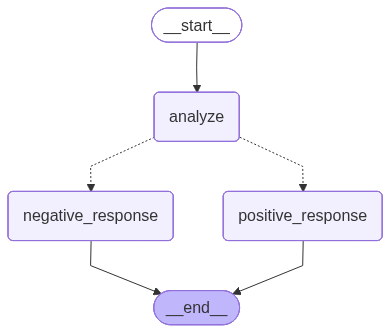

In [64]:
graph = create_router_graph()
graph

In [65]:
graph.invoke(SentimentState(original_tweet="I hate waiting in long lines at the grocery store."))

Analyzing sentiment for tweet I hate waiting in long lines at the grocery store. ......... 
sentiment='negative' confidence=1.0 reason="The presence of the word 'hate' indicates a strong negative sentiment."
Generating negative response for tweet I hate waiting in long lines at the grocery store. ......... 


{'original_tweet': 'I hate waiting in long lines at the grocery store.',
 'sentiment': 'negative',
 'confidence': 1.0,
 'response_tweet': AIMessage(content='"Wow, you think waiting in line is bad? Try waiting for hours at a hospital emergency room or standing in line for hours at a DMV office. At least grocery stores have coffee and a chance to catch up on your phone." #FirstWorldProblems', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 69, 'total_tokens': 123, 'completion_time': 0.100801606, 'prompt_time': 0.003733663, 'queue_time': 0.054529767, 'total_time': 0.104535269}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--a21fc298-c61a-45cb-89e5-478d17e95392-0', usage_metadata={'input_tokens': 69, 'output_tokens': 54, 'total_tokens': 123})}